In [1]:
import os
from grapher import *

### Isak Andersson - AI23

## <p style="text-align:center;">Group Project - Deep Learning</p>
# <p style="text-align:center;">Face Keypoint Detection</p>

##### *With **Asajad Hussein Abdul-Kadhom** and **Mikael Folkesson***
---

## 1. Introduction

As a group, we researched different approaches to teaching a neural net how to recognize eyes, nose and mouth in an image of a face and to then use the model to find these keypoints in a completely new image of a face. This project rapport aims to show our process and what results we found along the way, and some of the lessons learned. In short, in many cases there's no need to reinvent the wheel, but one needs to recognize how the wheel is built before asking it to carry the cart. What I mean by this is that relying on coding LLMs often bite you, even if it first gave you a great starting of point, and did a lot of the research for you initially.

The assignment was short and intensive, for better and for worse. We each started attacking the problem from our own personal directions, but met up almost daily to sync up. And lastly applied our combined research into a working data pipeline and model.

In the end, Github user [nalbert9](https://github.com/nalbert9/Facial-Keypoint-Detection/) supplied the best working model structure for our use case, and we edited it according to our data needs. I would also like to credit [Horst Possegger](https://scholar.google.com/citations?user=iWPrl3wAAAAJ&hl=en) and the [Graz University of Technology](https://www.uni-graz.at/en/) for supplying us with the AFLW dataset.

It should be said, that even though we've done this project as a group, our end results might differ since time ran out, and some of us might have found more/better/worse examples after our last sync with each other. And I personally hope to continue with this project even after it's completion!

## 2. Method

The dataset used is called [AFLW (Annotated Facial Landmarks in the Wild)](https://paperswithcode.com/dataset/aflw) and contains around 25,000 faces with varying number of annotations per image and face, and the images originally comes from the social media platform Flickr. The annotations used in this project were limited by scope and were as follows:
- Left eye, pupil (x, y)
- Right eye, pupil (x, y)
- Nose-tip (x, y)
- Mouth (center) (x, y)
- Face bounding box (x, y)
- Face bounding box (width, height)

AFLW also supplies more annotations such as additional keypoints, ethnicity, pose and sex, but these were left out based on a guessed performance limit that would mirror the length of the assignment.

### 2.1 Data processing

Although the data from AFLW came very well structured, there is some big gaps and NaN values. The decision was made to completely disregard any image that didn't have a full set of annotations of the annotations mentioned above. This, and the before mentioned missing annotations, left around 12,000 images.

Please see /data_pipeline.ipynb for all code surrounding the choice of images to use.

All remaining images where transformed in the following ways (utils.py -> gpu_transform()):
- Resized into 224x224 pixels and rearrange dimensions to fit our model.
- Normalize RGB values into values between 0 and 1.
- Adopt the ImageNet normalization mean and standard deviation.

<details>

<summary>gpu_transform()</summary>

```
def gpu_transform(image, device):
    image = torch.tensor(np.array(image)).permute(2, 0, 1).to(device).float() / 255.0
    image = torch.nn.functional.interpolate(image.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    image = (image - mean) / std
    return image
```

</details>

The reasoning behind these transformations came from experience, except the ImageNet values. Those values are credited to ImageNet and was found using a coding LLM.

### 2.2 Model structures

<p style="text-align:center;">
<img src="imgs/network_architecture.png" alt="nalbert9 network architecture (no bounding box)" width=1400>
</p>
<p style="text-align:center;">
<em>(fig. 1) nalbert9 network architecture (no bounding box)</em>
</p>

The best working model structure was taken from nalbert9 on github. However, nalbert9 was using many more keypoints and no bounding box which required some minor changes.

The tested model structures are as follows, in order of testing:
<details>
<summary>experiment with batch normalization (with bounding box)</summary>

```
Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_keypoints): Linear(in_features=512, out_features=8, bias=True)
  (fc_bbox): Linear(in_features=512, out_features=4, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        
        # Separate outputs
        keypoints = self.fc_keypoints(x)
        bbox = self.fc_bbox(x)
        
        return keypoints, bbox
```

</details>

<details>
<summary>nalbert9 (fixed output features, no bounding box)</summary>

```
nalbert_Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=8, bias=True) # out_features is changed to 8 (2(x,y)) from 136 (68(x,y)).
  (drop1): Dropout(p=0.25, inplace=False)
)

def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        x = self.fc3(x)
        
        return x
```

</details>

<details>
<summary>nalbert9 (fixed output features, with bounding box)</summary>

```
nalbert_Net_wBbox(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_keypoints): Linear(in_features=512, out_features=8, bias=True)
  (fc_bbox): Linear(in_features=512, out_features=4, bias=True)
  (drop1): Dropout(p=0.25, inplace=False)
)

def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        
        keypoints = self.fc_keypoints(x)
        bbox = self.fc_bbox(x)
        
        return keypoints, bbox
```

</details>

<details>
<summary>nalbert9 (better working variant, with bounding box, see comment at fc1)</summary>

```
nalbert_Net_wBbox(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True) # changed in_features when removing F.adaptive_avg_pool2d(x,1)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_keypoints): Linear(in_features=512, out_features=8, bias=True)
  (fc_bbox): Linear(in_features=512, out_features=4, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        
        keypoints = self.fc_keypoints(x)
        bbox = self.fc_bbox(x)
        
        return keypoints, bbox
```

</details>


### 2.3 Hardware and training optimization

All computers used to run these networks had access to different kind of CUDA accelerated hardware, and this ran combined with PyTorch as the main framework. As presented in gpu_transform(), the .to(device) sent data to VRAM. This transform method was one of the optimizations made, and almost halved the runtime of 50 epochs by itself when compared to doing the transformations on the cpu.

Other optimizations included batch size variations in torch.DataLoader within the train/test split function (utils.py). There was also some experimentation with the "num_workers=" kwarg in the DataLoader class, but was ultimately left alone due to the Windows Blue Screen issues it brought.

The models were all run for 50 epochs, where each epoch model was stored and the best model got continuously over-written by the new best model if better.
<details>
<summary>Like so (utils.py -> train()):</summary>

```
model_path = os.path.join(save_dir, f"model_epoch_{epoch_num}.pth")
        torch.save({'epoch': epoch_num, 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': avg_train_loss, 
                    'val_loss': avg_val_loss}, model_path)
        
        if save_best and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(save_dir, 'best_model.pth')
            torch.save({'epoch': epoch_num, 
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_loss': avg_train_loss, 
                        'val_loss': avg_val_loss}, best_model_path)
            print(f"Best model saved at epoch {epoch_num} with Val Loss: {avg_val_loss:.4f}")
```
</details>

Furthermore, the discovery was made that the 48th epoch often was the best, and that more than 50 epochs seemed excessive, no early-stopping was added to the training scenarios. Some exemptions to this were made during the network exploration.

### 2.4 Optimization and loss functions

For the optimization function, Adam was chosen because of it's speed. Experiments were made regarding learning rate, however, in these shown examples only a learning rate of 0.001 was used. Please see Asajad and Mikaels findings for more examples.

As for the loss function, two different losses were used, MSE for the facial keypoints, and smooth L1 loss (Huber) for the bounding box. These were then normalized and added together for a total loss value.

## 3. Analysis

Because of a slight miscalculation in early testing, the loss data gathered is not 100% uniform as in scaled to the same size. I found the curves interesting, and even though no inference were made using the BatchNormalization net, I wanted to show the chaos of un-normalized loss data.

### 3.1 Graphs

Here below, the four model versions are shown in five graphs. Number 1 and 2 are the same model, but with the loss shown without and with normalized calculated loss values. To summarize, no model really improves beyond 20 epochs, and interestingly all the "bad" models have a train loss "hump" in common at around epoch 20 before it starts decreasing.

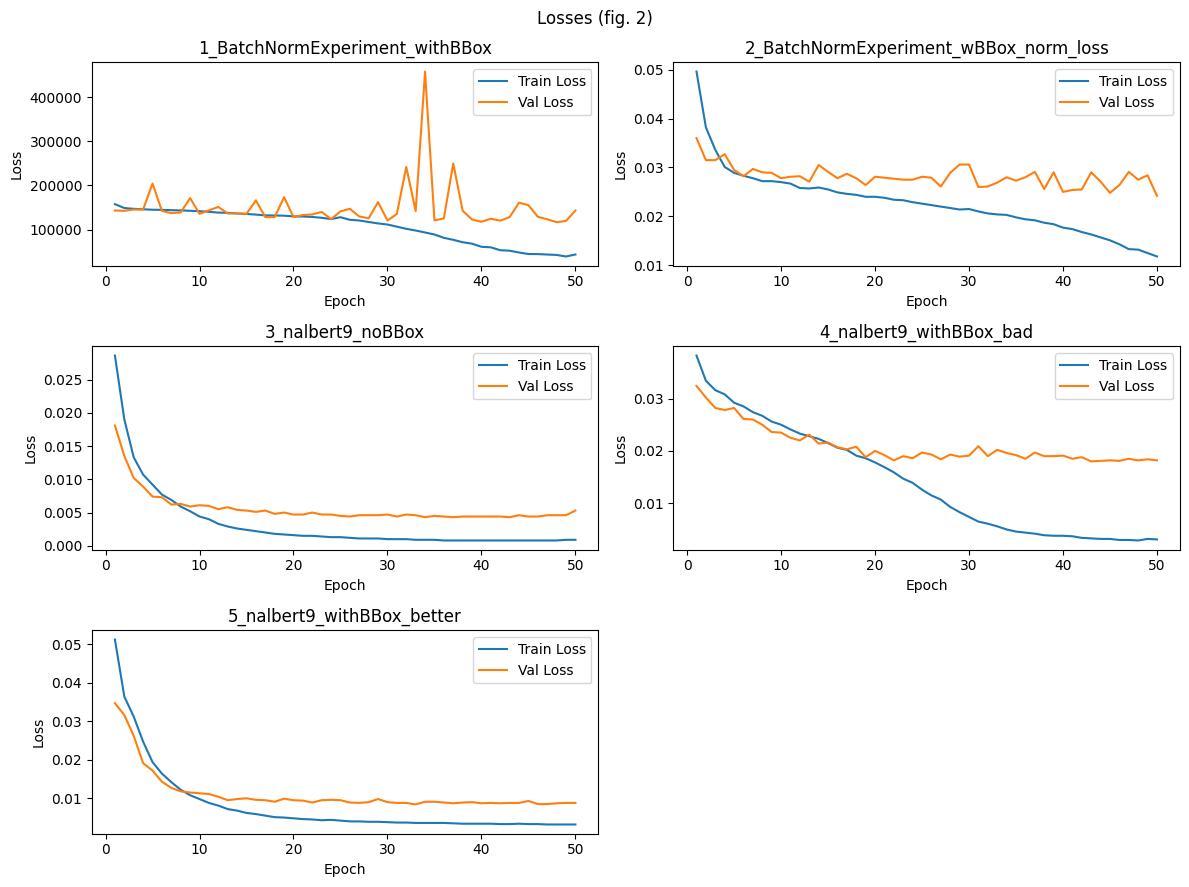

In [2]:
plot_grid_losses('logs/')

### 3.2 Inference

As for inference, the images chosen below will only include the "nalbert9" versions. The images were transformed in the same way as before, using gpu_transform(), to then to have plotted the denormalized keypoint and bounding box (x, y) coordinates onto them. Like so:

<details>
<summary>Inference code</summary>

#### For images with bounding boxes:
```
test_image = plt.imread(test_pic)
test_image = gpu_transform(test_image, "cuda").unsqueeze(0).to(device)

with torch.no_grad():
    pred_keypoints, pred_bbox = model(test_image)
    
pred_keypoints_np = pred_keypoints.cpu().numpy().reshape(-1, 2)
pred_bbox_np = pred_bbox.cpu().numpy().reshape(-1)
pred_keypoints_np[:, 0] *= test_image.shape[3]
pred_keypoints_np[:, 1] *= test_image.shape[2]
pred_bbox_np[0] *= test_image.shape[3]
pred_bbox_np[1] *= test_image.shape[2]
pred_bbox_np[2] *= test_image.shape[3]
pred_bbox_np[3] *= test_image.shape[2]

fig, ax = plt.subplots(1)
ax.imshow(test_image.cpu().squeeze().permute(1, 2, 0))

for (x, y) in pred_keypoints_np:
    ax.plot(x, y, 'go')
    
rect = patches.Rectangle((pred_bbox_np[0], pred_bbox_np[1]), pred_bbox_np[2], pred_bbox_np[3], linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect)
```

#### For images without bounding boxes:
```
test_image = plt.imread(test_pic)
test_image = gpu_transform(test_image, "cuda").unsqueeze(0).to(device)

with torch.no_grad():
    pred_keypoints= model(test_image)
    
pred_keypoints_np = pred_keypoints.cpu().numpy().reshape(-1, 2)
pred_keypoints_np[:, 0] *= test_image.shape[3]
pred_keypoints_np[:, 1] *= test_image.shape[2]


fig, ax = plt.subplots(1)
ax.imshow(test_image.cpu().squeeze().permute(1, 2, 0))

for (x, y) in pred_keypoints_np:
    ax.plot(x, y, 'go')

```

</details>

The "test img" below is the first [0] example of the test data that instance. And the "isak" image is an image of me (!) used as a live example, not being part of the original dataset.

It's clear that with this training structure, the model struggles with the bounding box. The first pair (a) shows the inference images relating to the loss curve for model number 4 in *(fig. 2)*, where the added test loss (keypoints + bboxes) reached 0.02. The second pair (b) relates to loss curve for the model number 5 reaching an added test loss of 0.015, and (c) to model loss curve number 3, where (c) were clearly the most accurate with a test loss of 0.0048.

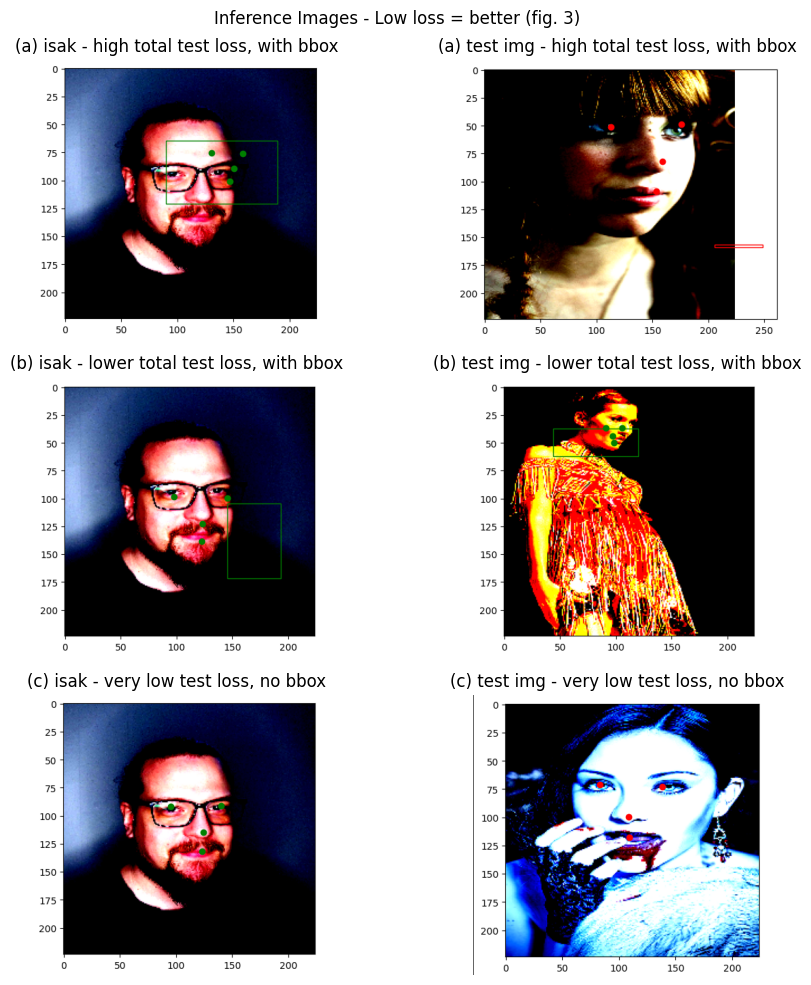

In [3]:
display_images(
    [img_path for img_path in os.listdir('./imgs/inference/')],
    figsize=(10, 10),
    titles=[
        "(a) isak - high total test loss, with bbox",
        "(a) test img - high total test loss, with bbox",
        "(b) isak - lower total test loss, with bbox",
        "(b) test img - lower total test loss, with bbox",
        "(c) isak - very low test loss, no bbox",
        "(c) test img - very low test loss, no bbox",
        ]
    )

Interestingly, the keypoints seems to get alway get pretty good results, even if the total loss is quite high, suggesting the nalbert9-inspired net originally was very well suited for keypoints only. But why? The bounding box is also defined partly as (x, y) coordinates. More on this in **4. Discussion**.

When removing the bounding boxes completely, the model seems very sure. At the time of writing this, I have not yet found a test image that couldn't be correctly annotated by the model.

## 4. Discussion

The main issue surrounding the addition of bounding boxes seems to be the different approaches of which the neural network layers sees the items it is looking for. Where key*points* really is just a point, but where the bounding box sides needs to account for many more factors such as head-tilt and obscuration. A nose is always between the eyes and mouth, but the outer edge of a face could be different from different sides. This combined with that the MSE loss function used for finding the keypoints is much easier to optimize compared to smoothL1. Also, the network has probably also given up on learning how to properly detect the bounding box, when getting a worth-while loss improvement for the keypoints alone. This could explain the "hump" mentioned in *3.1 Graphs*.

### 4.1 Personal thoughts

There's many more experiments I'd like to test. A limitation was set by myself to not try too much and too broadly for the reason of making the assignment manageable. However, this repo will be visited again, it feels like I've just gotten to scratch the already explored surface as to what is possible. The next couple of things I'd like to try are, in no particular order:

- parallel networks for bounding boxes and keypoints, not combined.
- more "plain" experimentation around network size, learning rates, etc.
- augmentation of images (please see Asajads progress with this).
- training the best trained model to also detect partial faces.
- testing on a live video feed.

The list goes on.

Again, I'd like to mention that our group have done the same job, but might've focused on slightly different things to write about in the end. Therefore there's surely many more interesting facts and encounters, that together with the rest of our research might reach better more insightful conclusions.

## 5. Tools

- [Network visualization tool (fig. 1)](https://alexlenail.me/NN-SVG/AlexNet.html)
- [StackOverflow](https://stackoverflow.com/)
- [Github](https://github.com/)
- [AFLW](https://paperswithcode.com/dataset/aflw)


- Mentionable extensions:
    - GitHub Copilot
    - Code Spell Checker (for spellchecking in markdown cells)